# references
* http://snappishproductions.com/blog/2018/01/03/class-activation-mapping-in-pytorch.html
* https://software.intel.com/en-us/articles/visualising-cnn-models-using-pytorch

In [648]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
import torchvision

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import skimage
import sys
import tqdm
import yaml

from addict import Dict
from tensorboardX import SummaryWriter

from dataset import PartAffordanceDataset, ToTensor, CenterCrop, Normalize
from model.resnet import ResNet50_convcam, ResNet50_linearcam


In [649]:
CONFIG = Dict(yaml.safe_load(open('./result/ResNet50_linearcam/config.yaml')))

In [650]:
data = PartAffordanceDataset(CONFIG.train_data,
                           config=CONFIG,
                           transform=transforms.Compose([
                               CenterCrop(CONFIG),
                               ToTensor(CONFIG),
                               Normalize()
                           ]))

In [651]:
loader = DataLoader(data, batch_size=1, shuffle=True, num_workers=CONFIG.num_workers)

In [652]:
model = ResNet50_linearcam(CONFIG.obj_classes, CONFIG.aff_classes)
model.load_state_dict(torch.load(CONFIG.result_path + '/best_accuracy_model.prm', map_location=lambda storage, loc: storage))
model.eval()

ResNet50_linearcam(
  (feature): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64,

### tensorベース, linear cam

In [653]:
class SaveFeatures():
    features = None
    def __init__(self, m):
        # register a hook  to save features
        self.hook = m.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, input, output):
        # save features
        self.features = output.to('cpu').data
                        
    def remove(self):
        self.hook.remove()

In [654]:
final_layer = list(model.feature.children())[-1]

In [655]:
activated_features = SaveFeatures(final_layer)

In [656]:
print(activated_features.features)

None


In [657]:
img_iter = iter(loader)

sample = img_iter.next()
img = sample['image']
img1 = img.clone()

pred = model(img)

print(activated_features.features.shape)

# object
pred[0][pred[0]>0.5] = 1
pred[0][pred[0]<=0.5] = 0

print(pred[0])

# affordance
pred[1][pred[1]>0.5] = 1
pred[1][pred[1]<=0.5] = 0

print(pred[1])

torch.Size([1, 2048, 8, 8])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],
       grad_fn=<IndexPutBackward>)
tensor([[1., 0., 1., 0., 0., 0., 0.]], grad_fn=<IndexPutBackward>)


In [658]:
params_fc_obj = list(model._modules.get('fc_obj').parameters())
weight_fc_obj = params_fc_obj[0].to('cpu').data

In [659]:
params_fc_aff = list(model._modules.get('fc_aff').parameters())
weight_fc_aff = params_fc_aff[0].to('cpu').data

In [660]:
def getCAM(features, weight_fc):
    '''
    features: feature map before GAP.  shape => (N, C, H, W)
    weight_fc: the weight of fully connected layer.  shape => (num_classes, C)
    cam: class activation map.  shape=> (N, num_classes, H, W)
    '''
    
    cam = F.conv2d(features, weight=weight_fc[:, :, None, None])
    
    return cam

In [661]:
cam_obj = getCAM(activated_features.features, weight_fc_obj)

In [662]:
cam_aff = getCAM(activated_features.features, weight_fc_aff)

In [663]:
# nonzero でインデックスの検索が可能
obj = []
for i in pred[0].nonzero():
    cam = cam_obj[i[0], i[1], :, :]
    cam -= torch.min(cam)
    cam /= torch.max(cam)
    obj.append(cam)

In [664]:
aff = []
for i in pred[1].nonzero():
    cam = cam_aff[i[0], i[1], :, :]
    cam -= torch.min(cam)
    cam /= torch.max(cam)
    aff.append(cam)

In [665]:
def reverse_normalize(x, mean=[0.2191, 0.2349, 0.3598], std=[0.1243, 0.1171, 0.0748]):
    x[0, :, :] = x[0, :, :] * std[0] + mean[0]
    x[1, :, :] = x[1, :, :] * std[1] + mean[1]
    x[2, :, :] = x[2, :, :] * std[2] + mean[2]
    return x

In [666]:
image = img.squeeze()
image = reverse_normalize(image)
image = image.numpy()
image = np.transpose(image,(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


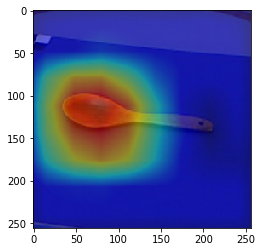

In [667]:
plt.imshow(image)
plt.imshow(skimage.transform.resize(obj[0].numpy(), (256, 256)), alpha=0.5, cmap='jet')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


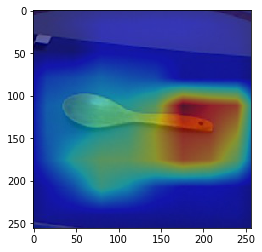

In [668]:
plt.imshow(image)
plt.imshow(skimage.transform.resize(aff[0].numpy(), (256, 256)), alpha=0.5, cmap='jet')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


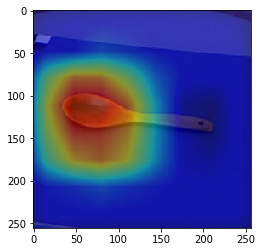

In [669]:
plt.imshow(image)
plt.imshow(skimage.transform.resize(aff[1].numpy(), (256, 256)), alpha=0.5, cmap='jet')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: list index out of range

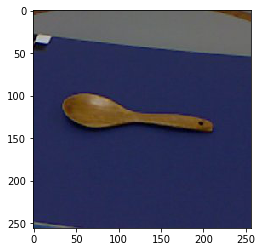

In [670]:
plt.imshow(image)
plt.imshow(skimage.transform.resize(aff[2].numpy(), (256, 256)), alpha=0.5, cmap='jet')

### tensorベース, conv cam

In [671]:
CONFIG = Dict(yaml.safe_load(open('./result/ResNet50_convcam/config.yaml')))

In [672]:
model = ResNet50_convcam(CONFIG.obj_classes, CONFIG.aff_classes)
model.load_state_dict(torch.load(CONFIG.result_path + '/best_accuracy_model.prm', map_location=lambda storage, loc: storage))
model.eval()

ResNet50_convcam(
  (feature): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 2

In [673]:
# img_iter = iter(loader)

# sample = img_iter.next()
# img = sample['image']

pred = model(img1)

# object
pred[0][pred[0]>0.5] = 1
pred[0][pred[0]<=0.5] = 0

print(pred[0])

# affordance
pred[1][pred[1]>0.5] = 1
pred[1][pred[1]<=0.5] = 0

print(pred[1])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],
       grad_fn=<AsStridedBackward>)
tensor([[1., 0., 1., 0., 0., 0., 0.]], grad_fn=<AsStridedBackward>)


In [674]:
cam_obj = pred[2]
cam_aff = pred[3]

In [675]:
# nonzero でインデックスの検索が可能
obj = []
for i in pred[0].nonzero():
    cam = cam_obj[i[0], i[1], :, :]
    cam -= torch.min(cam)
    cam /= torch.max(cam)
    obj.append(cam)

In [676]:
aff = []
for i in pred[1].nonzero():
    cam = cam_aff[i[0], i[1], :, :]
    cam -= torch.min(cam)
    cam /= torch.max(cam)
    aff.append(cam)

In [677]:
def reverse_normalize(x, mean=[0.2191, 0.2349, 0.3598], std=[0.1243, 0.1171, 0.0748]):
    x[0, :, :] = x[0, :, :] * std[0] + mean[0]
    x[1, :, :] = x[1, :, :] * std[1] + mean[1]
    x[2, :, :] = x[2, :, :] * std[2] + mean[2]
    return x

In [678]:
image1 = img1.squeeze()
image1 = reverse_normalize(image1)
image1 = image1.numpy()
image1 = np.transpose(image1,(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


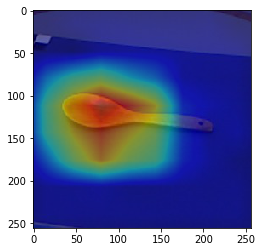

In [679]:
plt.imshow(image)
plt.imshow(skimage.transform.resize(obj[0].data.numpy(), (256, 256)), alpha=0.5, cmap='jet')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


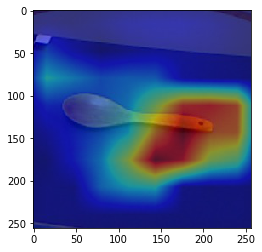

In [680]:
plt.imshow(image)
plt.imshow(skimage.transform.resize(aff[0].data.numpy(), (256, 256)), alpha=0.5, cmap='jet')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


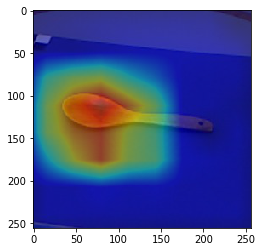

In [681]:
plt.imshow(image)
plt.imshow(skimage.transform.resize(aff[1].data.numpy(), (256, 256)), alpha=0.5, cmap='jet')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: list index out of range

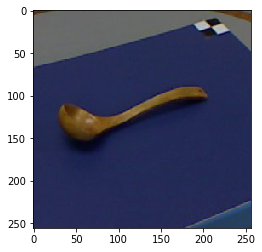

In [379]:
plt.imshow(image)
plt.imshow(skimage.transform.resize(aff[2].data.numpy(), (256, 256)), alpha=0.5, cmap='jet')